In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import roc_curve # 绘制ROC曲线
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,f1_score,recall_score,precision_score
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
medicareDataNew = pd.read_csv("D:\\AI_Code\\Feature_Engineering\\medicareDataNew.csv") #读取后来更新的文件


In [5]:
medicareDataNew.iloc[:,0].unique(),medicareDataNew.iloc[:,0].nunique()

(array([3.52120e+14, 3.52121e+14, 3.52126e+14, 3.52128e+14]), 4)

### 寻找缺失值

In [7]:
df_columns_nan_count = medicareDataNew.isnull().sum()
#会计算DataFrame中每一列缺失值的数量。返回的结果是一个Series，其中索引是列名，值是对应列中缺失值的数量。

In [8]:
df_nan_columns = []
for index in range(len(df_columns_nan_count)):
    if(df_columns_nan_count[index]!=0):
        df_nan_columns.append(index)
        

In [9]:
df_nan_columns  #说明csv标的71个属性有空缺值

[71]

In [10]:
medicareDataNew.iloc[:,71] #出院诊断LENTH_MAX有缺失值

0        29.0
1        20.0
2        29.0
3        16.0
4        33.0
         ... 
15995    28.0
15996    25.0
15997    30.0
15998     5.0
15999    34.0
Name: 出院诊断LENTH_MAX, Length: 16000, dtype: float64

### 补全缺失值，定义函数

In [11]:
def fillna(fillMethod, df=None, val=0):
    if df is None:
        df = medicareDataNew.copy()
        
    temp_df = df.copy() #创建df的副本
    
    if fillMethod == "solid":
        temp_df["出院诊断LENTH_MAX"] = temp_df["出院诊断LENTH_MAX"].fillna(val)
    elif fillMethod == "mean":
        temp_df["出院诊断LENTH_MAX"] = temp_df["出院诊断LENTH_MAX"].fillna(temp_df["出院诊断LENTH_MAX"].mean())
    elif fillMethod == "mode":
        temp_df["出院诊断LENTH_MAX"] = temp_df["出院诊断LENTH_MAX"].fillna(temp_df["出院诊断LENTH_MAX"].mode().iloc[0])  # mode() 返回一个 Series，需要取第一个值
    elif fillMethod == "forward_fill":
        temp_df["出院诊断LENTH_MAX"] = temp_df["出院诊断LENTH_MAX"].fillna(method='ffill')  # pad 是旧版pandas的用法，新版建议使用ffill
    elif fillMethod == "backward_fill":
        temp_df["出院诊断LENTH_MAX"] = temp_df["出院诊断LENTH_MAX"].fillna(method='bfill')
    elif fillMethod == "interpolate":
        temp_df["出院诊断LENTH_MAX"] = temp_df["出院诊断LENTH_MAX"].interpolate()
    else:
        raise ValueError("Invalid fill method specified")

    return temp_df
    
# interpolate() 是一个用于填充缺失值（NaN）的方法。
# 它根据现有数据的线性、指数、时间序列或其他插值方法来估算缺失值，并填充到数据集中。
# 导入 fancyimpute 库中的几个缺失值填充方法，包括BiScaler（双尺度标准化）、KNN（K-最近邻）
# 、NuclearNormMinimization（最小化核范数）和SoftImpute（软奇异值分解填充）。
#后面还有几种方法没用

In [12]:
fill_df = fillna('mode',medicareDataNew,5)
fill_df['出院诊断LENTH_MAX'][120],medicareDataNew['出院诊断LENTH_MAX'][120]   #说明空缺值确实填上了

(22.0, nan)

## 异常值处理，主要就是去除异常点，过采样，欠采样

#### 局部离群因子（LOF，Local Outlier Factor）的异常点检测算法 结果发现一个都没检测出来

In [13]:
from sklearn.neighbors import LocalOutlierFactor

data = fill_df.values
# 实例化LOF对象，n_neighbors表示计算局部密度时参考的邻居数量
clf = LocalOutlierFactor(n_neighbors=20, contamination='auto')
# 计算每个样本的LOF得分
scores = clf.fit_predict(data)
# scores中正值表示正常样本，-1表示异常样本
outliers = (scores == -1)
# 将异常点标识添加回原DataFrame
fill_df['is_outlier'] = outliers
# 输出异常点
print(fill_df[fill_df['is_outlier']])

# from collections import Counter
# element_to_count = True
# counter = Counter(outliers)
# count = counter[element_to_count]
# print(count)  0个

Empty DataFrame
Columns: [个人编码, 一天去两家医院的天数, 就诊的月数, 月就诊天数_MAX, 月就诊天数_AVG, 月就诊医院数_MAX, 月就诊医院数_AVG, 就诊次数_SUM, 月就诊次数_MAX, 月就诊次数_AVG, 月统筹金额_MAX, 月统筹金额_AVG, 月药品金额_MAX, 月药品金额_AVG, 医院_就诊天数_MAX, 医院_就诊天数_AVG, 医院_统筹金_MAX, 医院_统筹金_AVG, 医院_药品_MAX, 医院_药品_AVG, 医院编码_NN, 顺序号_NN, 交易时间DD_NN, 交易时间YYYY_NN, 交易时间YYYYMM_NN, 住院天数_SUM, 个人账户金额_SUM, 统筹支付金额_SUM, ALL_SUM, 可用账户报销金额_SUM, 药品费发生金额_SUM, 药品费自费金额_SUM, 药品费申报金额_SUM, 贵重药品发生金额_SUM, 中成药费发生金额_SUM, 中草药费发生金额_SUM, 检查费发生金额_SUM, 检查费自费金额_SUM, 检查费申报金额_SUM, 贵重检查费金额_SUM, 治疗费发生金额_SUM, 治疗费自费金额_SUM, 治疗费申报金额_SUM, 手术费发生金额_SUM, 手术费自费金额_SUM, 手术费申报金额_SUM, 床位费发生金额_SUM, 床位费申报金额_SUM, 医用材料发生金额_SUM, 高价材料发生金额_SUM, 医用材料费自费金额_SUM, 成分输血申报金额_SUM, 其它发生金额_SUM, 其它申报金额_SUM, 一次性医用材料申报金额_SUM, 起付线标准金额_MAX, 起付标准以上自负比例金额_SUM, 医疗救助个人按比例负担金额_SUM, 最高限额以上金额_SUM, 基本统筹基金支付金额_SUM, 公务员医疗补助基金支付金额_SUM, 城乡救助补助金额_SUM, 基本个人账户支付_SUM, 非账户支付金额_SUM, 本次审批金额_SUM, 补助审批金额_SUM, 医疗救助医院申请_SUM, 残疾军人补助_SUM, 民政救助补助_SUM, 城乡优抚补助_SUM, 出院诊断病种名称_NN, 出院诊断LENTH_MAX, 药品在总金额中的占比, 个人支付的药品占比, 检查总费用在总金额占比, 个人支付检查费用占比, 治疗费用在总金额占比, 个人支付治

#### 马氏距离去除异常点  一共有800个异常点

In [14]:
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler

# 假设 df 是你的 DataFrame，且只包含数值型特征
numerical_df = fill_df.select_dtypes(include=[np.number])

# 首先对数据进行标准化，以便更好地计算协方差矩阵
scaler = StandardScaler()
scaled_df = scaler.fit_transform(numerical_df)

# 计算均值向量和协方差矩阵
cov_estimator = EmpiricalCovariance()
cov_matrix = cov_estimator.fit(scaled_df).covariance_
mean_vector = scaled_df.mean(axis=0)

# 计算每个样本的马氏距离
mahalanobis_distances = []

for i in range(scaled_df.shape[0]):
    sample = scaled_df[i, :]  # 直接获取一维子数组
    mahalanobis_distance = mahalanobis(sample, mean_vector, cov_matrix)
    mahalanobis_distances.append(mahalanobis_distance)

# 将计算出的马氏距离转换为 Series
mahalanobis_distances = pd.Series(mahalanobis_distances, index=numerical_df.index)

# 继续后面的代码，例如设定阈值和标记异常点
threshold = np.percentile(mahalanobis_distances, 95)
is_outlier = mahalanobis_distances > threshold

# # 更新原始 DataFrame 中的一列来记录是否为异常点
fill_df['is_outlier'] = is_outlier

fill_df[fill_df['is_outlier']==False]  #is_outlier表示是正常点

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES,is_outlier
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0,False
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0,False
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0,False
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0,False
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,3.521280e+14,0,6,8,6.500000,3,3.000000,40,8,6.666667,...,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0,False
15996,3.521280e+14,0,6,8,6.833333,2,2.000000,42,9,7.000000,...,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0,False
15997,3.521280e+14,4,6,8,6.333333,2,2.000000,42,9,7.000000,...,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0,False
15998,3.521280e+14,0,6,5,3.333333,1,1.000000,20,5,3.333333,...,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0,False


### 连续型特征处理

使用sklearn库标准化数据

In [16]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

def fit_transform_data(method,df):
    df_array = df.values
#     columns = df.columns.tolist()
    if method=='StandardScaler':
        scaler = StandardScaler()
        scaler_data = scaler.fit_transform(df_array)
        return scaler_data
    elif method=='Normalizer':
        scaler = Normalizer()
        scaler_data = scaler.fit_transform(df_array)
        return scaler_data
    elif method=='MinMaxScaler':
        scaler = MinMaxScaler()
        scaler_data = scaler.fit_transform(df_array)
        return scaler_data

    
# transform_array_data = fit_transform_data('StandardScaler',fill_df) 
# transform_array_data
# #标准化，返回值为标准化后的数据
# StandardScaler().fit_transform(iris.data)
# #归一化，返回值为归一化后的数据
# Normalizer().fit_transform(iris.data)
# #区间缩放，返回值为缩放到[0, 1]区间的数据
# MinMaxScaler().fit_transform(iris.data)
# 压缩范围
# 有些分类变量的少部分取值可能占据了90%的case，这种情况下可以采用预测模型、领域专家、或者简单的频率分布统计。
# 具体问题具体分析，高频和低频都是需要特别处理的地方，抛弃效果不好时，可以考虑采样（高频）或上采样（低频），。

#### 定义训练模型的函数

In [18]:
prob_result = []
clfs_fited = []

def train_models(X_train,y_train,X_valid,y_valid,clf):
    pipe = Pipeline([
        ('scaler',StandardScaler()),
        ('clf',clf),
    ])
    print("%s: "%clf.__class__.__name__)
    pipe.fit(X_train,y_train)
    clf = pipe.named_steps['clf']# 得到相应的分类器
    clfs_fited.append(clf)  # 收集分类器
    y_pred = clf.predict(X_valid)
    fraud_prob = clf.predict_proba(X_valid)[:,1]  # 1 表示欺诈
    prob_result.append(fraud_prob)  #添加验证集欺诈概率
    m = confusion_matrix(y_valid,y_pred)  #混淆矩阵
    #     使用 brier_score_loss 函数计算验证集中每个样本对应的预测概率与真实标签之间的Brier得分损失，
    #     并将结果存储在变量 clf_score 中。值越小越好
#     clf_score = brier_score_loss(y_valid,fraud_prob,pos_label=y_valid.max())
    clf_score = brier_score_loss(y_valid,y_pred)
    print("\tBrier: %1.5f" % (clf_score))#特别是在二分类或多分类问题中，它可以评估模型预测的类别概率分布与实际观测到的标签之间的差距。
    print("\tPrecision: %1.5f" % precision_score(y_valid, y_pred)) #精确率是指预测为正类的样本中实际为正类的比例，
    print("\tRecall: %1.5f" % recall_score(y_valid, y_pred))  #召回率是指实际为正类的样本中被正确预测出来的比例，
    print("\tF1: %1.5f" % f1_score(y_valid, y_pred))  #F1分数是精确率（Precision）和召回率（Recall）的调和平均数，能够较好地反映模型在正类样本上的综合表现。
#     它计算的是ROC曲线下的面积（AUC, Area Under the Curve）。
#     ROC曲线描绘了真正率（True Positive Rate, TPR）与假正率（False Positive Rate, FPR）之间的关系。
#     真正率（TPR, Recall）：被正确预测为正类的样本数占所有实际为正类样本数的比例。
#     假正率（FPR）：被错误预测为正类但实际上为负类的样本数占所有实际为负类样本数的比例。
#     值越大越好
    print("\tauc: %1.5f" % roc_auc_score(y_valid, fraud_prob))
#      模型预测结果与真实标签之间的正确匹配率。简单来说，它是正确预测样本数占总样本数的比例。
#     某些时候并不准确，需要考虑更精细的指标
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, y_pred))

#主要看precision 精度

下一步每个功能先写好函数，然后统一调用
然后分别不同数据训练模型，结合马氏距离，
下面PCA也是如此

### 定义训练函数，训练分类模型

In [19]:
def train_classfication_models(X_train,y_train,X_valid,y_valid,clfs):
    for clf in clfs:
        train_model(X_train,y_train,X_valid,y_valid,clf)
        print("\n")

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans
import random
from scipy.stats import ttest_ind

In [21]:
important_columns_first = ['基本统筹基金支付金额_SUM','本次审批金额_SUM','药品费申报金额_SUM','药品费发生金额_SUM',
                     '月药品金额_MAX','月统筹金额_AVG','治疗费申报金额_SUM','ALL_SUM']
# 月药品金额_MAX(医院_药品_MAX和这个差不多，要稍微差一点)

important_columns_second = ['统筹支付金额_SUM','月就诊次数_MAX','就诊次数_SUM','起付标准以上自负比例金额_SUM',
                            '可用账户报销金额_SUM','非账户支付金额_SUM','医院_统筹金_AVG',
                            '月就诊天数_MAX','月就诊天数_AVG','月统筹金额_MAX']
important_columns_third = ['医院_统筹金_MAX','贵重药品发生金额_SUM','医疗救助个人按比例负担金额_SUM',
                           '医疗救助医院申请_SUM','个人账户金额_SUM','一天去两家医院的天数']

important_columns_total = important_columns_first + important_columns_second + important_columns_third

len(important_columns_total),len(list(set(important_columns_total)))

# 列出得到的重要的特征

(24, 24)

In [22]:
fill_df
fill_df.loc[:,important_columns_total]
# fill_df.iloc[:,-1]

,基本统筹基金支付金额_SUM,本次审批金额_SUM,药品费申报金额_SUM,药品费发生金额_SUM,月药品金额_MAX,月统筹金额_AVG,治疗费申报金额_SUM,ALL_SUM,统筹支付金额_SUM,月就诊次数_MAX,...,医院_统筹金_AVG,月就诊天数_MAX,月就诊天数_AVG,月统筹金额_MAX,医院_统筹金_MAX,贵重药品发生金额_SUM,医疗救助个人按比例负担金额_SUM,医疗救助医院申请_SUM,个人账户金额_SUM,一天去两家医院的天数
0,15247.76,16942.04,15929.04,16171.75,3901.45,2541.293333,128.0,17218.75,15247.76,7,...,5082.586667,7,5.666667,3501.18,7553.00,1984.60,0.0,0.0,1970.99,0
1,9824.15,10915.75,10418.95,10698.92,2449.13,1637.358333,150.0,11195.72,9824.15,4,...,4912.075000,4,2.500000,2217.66,9500.07,2264.73,0.0,0.0,1371.57,0
2,15498.32,17840.03,13926.88,14211.17,3302.06,2583.053333,3538.0,18135.52,15498.32,9,...,5166.106667,8,6.166667,3360.55,9161.73,0.00,0.0,0.0,2637.20,8
3,12346.32,13718.22,6291.22,6292.38,1500.12,2057.720000,7427.0,13719.38,12346.32,6,...,6173.160000,6,3.666667,3030.61,11622.17,0.00,0.0,0.0,1373.06,0
4,13177.89,14642.13,14402.13,14507.54,2563.26,2196.315000,240.0,14747.54,13177.89,5,...,13177.890000,5,4.333333,2332.45,13177.89,2367.68,0.0,0.0,1569.65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,12837.08,14263.44,14072.44,14142.21,3121.72,2139.513333,191.0,14333.21,12837.08,8,...,4279.026667,8,6.500000,2831.13,7094.15,1246.72,0.0,0.0,1496.13,0
15996,10196.33,11995.70,11123.80,11179.38,2133.65,2070.225000,477.0,12059.68,12421.35,9,...,6210.675000,8,6.833333,2369.03,9697.88,1391.84,0.0,0.0,750.84,0
15997,23854.12,26504.62,20486.62,20789.52,4897.23,3975.686667,6018.0,26879.52,23854.12,9,...,11927.060000,8,6.333333,5421.56,12453.45,0.00,0.0,0.0,3025.40,4
15998,22266.53,24766.48,23928.78,26037.31,6289.22,3711.088333,173.0,26924.61,22266.53,5,...,22266.530000,5,3.333333,5270.74,22266.53,21084.46,0.0,0.0,4658.08,0


In [23]:
#切分数据
X_train,X_valid,y_train,y_valid = train_test_split(fill_df.loc[:,important_columns_first].values,fill_df.iloc[:,-1].values,test_size=0.2,random_state=666)
# fill_df.iloc[:,-2]  RES

In [24]:
log_clf = LogisticRegression(C=1e5,class_weight='balanced',n_jobs=-1) 
train_models(X_train,y_train,X_valid,y_valid,log_clf)

LogisticRegression: 
	Brier: 0.95531
	Precision: 0.04469
	Recall: 1.00000
	F1: 0.08555
	auc: 0.50000
	Accuracy: 0.04469



In [25]:
Ganssian_clf = GaussianNB()
train_models(X_train,y_train,X_valid,y_valid,Ganssian_clf)

GaussianNB: 
	Brier: 0.95531
	Precision: 0.04469
	Recall: 1.00000
	F1: 0.08555
	auc: 0.50000
	Accuracy: 0.04469



In [26]:
# #贝叶斯朴素分类器不标准化数据
# gauss1_clf = GaussianNB()
# gauss1_clf = gauss1_clf.fit(X_train,y_train)
# gauss1_pred = gauss1_clf.predict(X_valid)
# gauss1_prob = gauss1_clf.predict_proba(X_valid)[:,1]


# print("\tBrier: %1.5f" % (brier_score_loss(y_valid,gauss1_pred)))
# print("\tPrecision: %1.5f" % precision_score(y_valid, gauss1_pred)) 
# print("\tRecall: %1.5f" % recall_score(y_valid, gauss1_pred))  
# print("\tF1: %1.5f" % f1_score(y_valid, gauss1_pred)) 
# print("\tauc: %1.5f" % roc_auc_score(y_valid, gauss1_prob))
# print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, gauss1_pred))


In [27]:
randforest_clf = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=5,class_weight='balanced')
train_models(X_train,y_train,X_valid,y_valid,randforest_clf)

RandomForestClassifier: 
	Brier: 0.95531
	Precision: 0.04469
	Recall: 1.00000
	F1: 0.08555
	auc: 0.49353
	Accuracy: 0.04469



In [28]:
extratree_clf = ExtraTreesClassifier(n_estimators=300,max_depth=10,min_samples_split=5,class_weight='balanced')
train_models(X_train,y_train,X_valid,y_valid,extratree_clf)

ExtraTreesClassifier: 
	Brier: 0.95531
	Precision: 0.04469
	Recall: 1.00000
	F1: 0.08555
	auc: 0.49943
	Accuracy: 0.04469



In [29]:
# #随机森岭变体不标准化数据
# extraTree_clf = ExtraTreesClassifier()
# extraTree_clf = extraTree_clf.fit(X_train,y_train)
# extraTree_pred = extraTree_clf.predict(X_valid)
# extraTree_prob = extraTree_clf.predict_proba(X_valid)[:,1]

# print("\tBrier: %1.5f" % (brier_score_loss(y_valid,extraTree_pred)))
# print("\tPrecision: %1.5f" % precision_score(y_valid, extraTree_pred)) 
# print("\tRecall: %1.5f" % recall_score(y_valid, extraTree_pred))  
# print("\tF1: %1.5f" % f1_score(y_valid, extraTree_pred)) 
# print("\tauc: %1.5f" % roc_auc_score(y_valid, extraTree_prob))
# print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, extraTree_pred))


In [30]:
gradientBoost_clf = GradientBoostingClassifier(n_estimators=100,max_depth=8,min_samples_split=4,learning_rate=0.01)

train_models(X_train,y_train,X_valid,y_valid,gradientBoost_clf)

GradientBoostingClassifier: 
	Brier: 0.95531
	Precision: 0.04469
	Recall: 1.00000
	F1: 0.08555
	auc: 0.49651
	Accuracy: 0.04469



In [32]:
import xgboost as xgb
xgb_clf_important = xgb.XGBClassifier(objective='binary:logistic',  # 根据问题类型选择目标函数
                        n_estimators=300,  # 树的数量（提升次数）
                        max_depth=5,  # 树的最大深度
                        learning_rate=0.1,  # 学习率
                        # 其他参数...
                        )
                    
# 使用训练集训练模型
xgb_clf_important.fit(X_train, y_train)

# 对验证集进行预测
y_pred_valid = xgb_clf_important.predict(X_valid)

# 计算验证集上的准确率
accuracy_valid_important = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy: {:.4f}".format(accuracy_valid_important ))

Validation Accuracy: 0.9900


## 特征交叉 通过用十几个特征来训练模型，发现准确率还会降低，所以试试特征交叉构造

In [33]:
fill_df_importantcolumns = fill_df.loc[:,important_columns_total]
# 对于简单的特征交叉，可以使用 pandas 的 `apply` 函数配合 lambda 表达式
fill_df_importantcolumns['药品费申报/本次审批'] = fill_df_importantcolumns['药品费申报金额_SUM']/fill_df_importantcolumns['本次审批金额_SUM']

fill_df_importantcolumns['统筹支付/月统筹金额_MAX'] = fill_df_importantcolumns['统筹支付金额_SUM']/fill_df_importantcolumns['月统筹金额_MAX']

fill_df_importantcolumns['起付标准以上自负比例/药品费申报金额_SUM'] = fill_df_importantcolumns['起付标准以上自负比例金额_SUM']/fill_df_importantcolumns['药品费申报金额_SUM']

fill_df_importantcolumns['月就诊次数_MAX/月统筹金额_AVG'] = fill_df_importantcolumns['月就诊次数_MAX']*fill_df_importantcolumns['月统筹金额_AVG']

fill_df_importantcolumns['月就诊次数_MAX/统筹支付金额_SUM'] = fill_df_importantcolumns['月就诊次数_MAX']/fill_df_importantcolumns['统筹支付金额_SUM']

fill_df_importantcolumns['药品费申报金额_SUM/治疗费申报金额_SUM'] = fill_df_importantcolumns['药品费申报金额_SUM']/fill_df_importantcolumns['治疗费申报金额_SUM']

fill_df_importantcolumns['药品费发生金额_SUM/药品费申报金额_SUM'] = fill_df_importantcolumns['药品费发生金额_SUM']/fill_df_importantcolumns['药品费申报金额_SUM']

# fill_df_importantcolumns['起付标准以上自负比例/药品费申报金额_SUM'] = fill_df_importantcolumns['起付标准以上自负比例金额_SUM']/fill_df_importantcolumns['药品费申报金额_SUM']



#### 使用构造之后的特征和构造之前的特征，训练模型,有可能出现无穷大，空值等情况

In [34]:
fill_df_importantcolumns.replace([np.inf, -np.inf], np.nan, inplace=True)
fill_df_importantcolumns.fillna(fill_df_importantcolumns.mode().iloc[0], inplace=True)  # 以均值填充缺失值

In [35]:
X_train_create1,X_valid_create1,y_train_create1,y_valid_create1 = train_test_split(fill_df_importantcolumns.values,fill_df.iloc[:,-2].values,test_size=0.2,random_state=2)


#### 交叉特征和原特征一起训练模型，效果也还好

In [36]:
import xgboost as xgb
xgb_clf_create1 = xgb.XGBClassifier(objective='binary:logistic',  # 根据问题类型选择目标函数
                        n_estimators=300,  # 树的数量（提升次数）
                        max_depth=10,  # 树的最大深度
                        learning_rate=0.1,  # 学习率
                        # 其他参数...
                        )
                    
# 使用训练集训练模型
xgb_clf_create1.fit(X_train_create1, y_train_create1)

# 对验证集进行预测
y_pred_valid = xgb_clf_create1.predict(X_valid_create1)

# 计算验证集上的准确率
accuracy_valid_create1 = accuracy_score(y_valid_create1, y_pred_valid)
print("Validation Accuracy: {:.4f}".format(accuracy_valid_create1 ))

Validation Accuracy: 0.9597


In [37]:
gradientBoost_clf_create1 = GradientBoostingClassifier(n_estimators=100,max_depth=8,min_samples_split=4,learning_rate=0.01)

train_models(X_train_create1,y_train_create1,X_valid_create1,y_valid_create1,gradientBoost_clf_create1)

GradientBoostingClassifier: 
	Brier: 0.05500
	Precision: 0.00000
	Recall: 0.00000
	F1: 0.00000
	auc: 0.42732
	Accuracy: 0.94500



#### 只使用交叉特征,效果也一般，不是很理想

In [38]:
X_train_create2,X_valid_create2,y_train_create2,y_valid_create2 = train_test_split(fill_df_importantcolumns.drop(columns=important_columns_total,inplace=False).values,fill_df.iloc[:,-2].values,test_size=0.2,random_state=2)


In [39]:
import xgboost as xgb
xgb_clf_create2 = xgb.XGBClassifier(objective='binary:logistic',  # 根据问题类型选择目标函数
                        n_estimators=300,  # 树的数量（提升次数）
                        max_depth=10,  # 树的最大深度
                        learning_rate=0.1,  # 学习率
                        # 其他参数...
                        )
                    
# 使用训练集训练模型
xgb_clf_create2.fit(X_train_create2, y_train_create2)

# 对验证集进行预测
y_pred_valid = xgb_clf_create2.predict(X_valid_create2)

# 计算验证集上的准确率
accuracy_valid_create2 = accuracy_score(y_valid_create2, y_pred_valid)
print("Validation Accuracy: {:.4f}".format(accuracy_valid_create2 ))

Validation Accuracy: 0.9556


In [40]:
gradientBoost_clf_create2 = GradientBoostingClassifier(n_estimators=100,max_depth=8,min_samples_split=4,learning_rate=0.01)

train_models(X_train_create2,y_train_create2,X_valid_create2,y_valid_create2,gradientBoost_clf_create2)

GradientBoostingClassifier: 
	Brier: 0.05969
	Precision: 0.10000
	Recall: 0.01143
	F1: 0.02051
	auc: 0.59882
	Accuracy: 0.94031



In [41]:
log_clf_create2 = LogisticRegression(C=1e5,class_weight='balanced',n_jobs=-1) 

log_clf_create2.fit(X_train_create2,y_train_create2)
y_log_pred = log_clf_create2.predict(X_valid_create2)
accuracy_valid = accuracy_score(y_log_pred,y_valid_create2)
print(f"Accuracy:{accuracy_valid}")

Accuracy:0.829375


In [42]:
randforest_clf_create2 = RandomForestClassifier(n_estimators=500,max_depth=10,min_samples_split=5,class_weight='balanced')

train_models(X_train_create2,y_train_create2,X_valid_create2,y_valid_create2,randforest_clf_create2)

RandomForestClassifier: 
	Brier: 0.05719
	Precision: 0.00000
	Recall: 0.00000
	F1: 0.00000
	auc: 0.58929
	Accuracy: 0.94281



# 特征提取，特征降维

#### PCA主成分分析,总的来说，特征也多，准确率越高，想办法把特征数降下来

In [43]:
import xgboost as xgb
def xgboost_accuracy(X_train,y_train,X_valid,y_valid):
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',  # 根据问题类型选择目标函数
                        n_estimators=300,  # 树的数量（提升次数）
                        max_depth=5,  # 树的最大深度
                        learning_rate=0.1,  # 学习率
                        # 其他参数...
)
                    
    # 使用训练集训练模型
    xgb_clf.fit(X_train, y_train)

    # 对验证集进行预测
    y_pred_valid = xgb_clf.predict(X_valid)

    # 计算验证集上的准确率
    accuracy_valid = accuracy_score(y_valid, y_pred_valid)
    return accuracy_valid


In [44]:
# fill_df.shape

In [45]:
n_components = []
accuracy_rates = []
#先切分数据集
# X_train_pca,X_valid_pca,y_train_pca,y_valid_pca = train_test_split(fill_df.loc[:,important_columns_first+important_columns_second].values,fill_df.iloc[:,-1].values,test_size=0.2,random_state=666)

x_data = StandardScaler().fit_transform(fill_df.loc[:,important_columns_total])
X_train_pca,X_valid_pca,y_train_pca,y_valid_pca = train_test_split(x_data,fill_df.iloc[:,-1].values,test_size=0.2,random_state=666)

from sklearn.decomposition import PCA

def plot_components_accuracy():
    for n_component in range(2,24):
        #先拟合数据，得到降维参数，指标
        pca_clf = PCA(n_components=n_component).fit(X_train_pca)
        X_train_pca_after = pca_clf.transform(X_train_pca)
        X_valid_pca_after = pca_clf.transform(X_valid_pca)
        
        #训练模型，得到准确率
        pca_accuracy = xgboost_accuracy(X_train_pca_after,y_train_pca,X_valid_pca_after,y_valid_pca)
        #添加准确率
        n_components.append(n_component)
        accuracy_rates.append(pca_accuracy)
        
#主成分分析法，返回降维后的数据
#参数n_components为主成分数目


In [47]:
plot_components_accuracy()

In [107]:
accuracy_rates

[0.9575,
 0.958125,
 0.95875,
 0.95875,
 0.9603125,
 0.9628125,
 0.9628125,
 0.9634375,
 0.963125,
 0.96375,
 0.9634375,
 0.9621875,
 0.9634375,
 0.96375,
 0.964375,
 0.96375,
 0.9640625,
 0.96375,
 0.96375,
 0.965,
 0.964375,
 0.9634375]

In [108]:
max(accuracy_rates),accuracy_rates.index(max(accuracy_rates))+2

(0.965, 21)

Text(0, 0.5, '模型准确率')

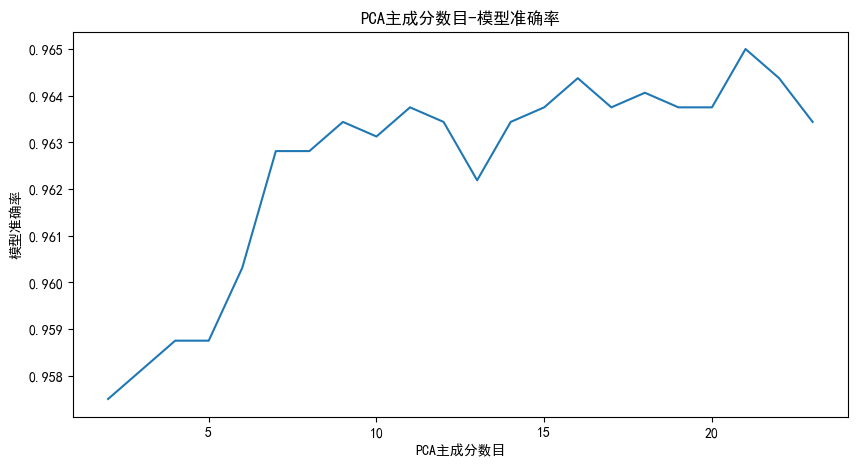

In [109]:
plt.figure(figsize=(10,5))
plt.plot(n_components,accuracy_rates)
plt.title("PCA主成分数目-模型准确率")
plt.xlabel("PCA主成分数目")
plt.ylabel("模型准确率")


## 使用PCA结合smote

In [10]:
# fill_df.to_csv("./fill_df.csv",index=False)   
fill_df = pd.read_csv("./fill_df.csv")

In [14]:
x_data = StandardScaler().fit_transform(fill_df.loc[:,important_columns_total])
X_train_pca,X_valid_pca,y_train_pca,y_valid_pca = train_test_split(fill_df.loc[:,important_columns_total].values,fill_df.iloc[:,-1].values,test_size=0.2,random_state=666)

y_valid_pca.shape[0]


3200

In [17]:
from sklearn import svm
import xgboost as xgb
def get_ExtraTree_accuracy(X_train,X_valid,y_train,y_valid):
    """
        定义函数，计算smote之后，测试原数据的准确率
    """
    # log_clf = LogisticRegression(C=1e5,class_weight='balanced',n_jobs=-1,random_state=666)
    # clf3 = log_clf.fit(X_train,y_train)
    # y_pred3 = clf3.predict(X_valid)
    # y_pred3_prob = clf3.predict_proba(X_valid)[:,1]
    
    # extraTree_clf2 = ExtraTreesClassifier(max_depth=None,min_samples_split=2,n_estimators=150)
    # clf3 = extraTree_clf2.fit(X_train,y_train)
    # y_pred1 = clf3.predict(X_valid)
    # y_pred1_prob = clf3.predict_proba(X_valid)[:,1]

    # gauss_clf = GaussianNB()
    # clf3 = gauss_clf.fit(X_train,y_train)
    # y_pred3 = clf3.predict(X_valid)
    # y_pred3_prob = clf3.predict_proba(X_valid)[:,1]

    # randforest_clf = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_split=5,class_weight='balanced')
    # clf1 = randforest_clf.fit(X_train,y_train)
    # y_pred1 = clf1.predict(X_valid)
    # y_pred1_prob = clf1.predict_proba(X_valid)

    # gradientBoost_clf_create2 = GradientBoostingClassifier(n_estimators=100,max_depth=8,min_samples_split=4,learning_rate=0.01)
    # clf3 = gradientBoost_clf_create2.fit(X_train,y_train)
    # y_pred3 = clf3.predict(X_valid)
    # y_pred3_prob = clf3.predict_proba(X_valid)[:,1]

    # xgb_clf = xgb.XGBClassifier(objective='binary:logistic',n_estimators=300,max_depth=5, learning_rate=0.1)
    # xgb_clf = xgb.XGBClassifier(objective='binary:logistic',n_estimators=300,reg_alpha=0.5,reg_lambda=1.0,max_depth=5, learning_rate=0.1)
    # clf3 = xgb_clf.fit(X_train,y_train)
    # y_pred3 = clf3.predict(X_valid)
    # y_pred3_prob = clf3.predict_proba(X_valid)[:,1]

    svm_clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr',probability=True)  # 这里使用线性核函数
    clf2 = svm_clf.fit(X_train, y_train)
    y_pred1 = clf2.predict(X_valid)
    y_pred1_prob = clf2.predict_proba(X_valid)


    # def distribute_weight(array1, array2):
    # results = []
    # for index in range(y_pred1_prob.shape[0]):
    #     list1 = y_pred1_prob[index]  # 拿到每个一维数组
    #     list2 = y_pred2_prob[index]
    #     not_fraud_rate = list1[0]*0.5 + list2[0]*0.5
    #     fraud_rate = 1 - not_fraud_rate
    #     # fraud_rate = list1[1]*0.5 + list2[1]*0.5
    #     if fraud_rate > not_fraud_rate:
    #         results.append(1)
    #     else:
    #         results.append(0)
            
    # # # return np.array(results)
    # results = np.array(results)

    dismatch_X = []
    dismatch_y = []
    for index in range(y_valid.shape[0]):
        if(y_valid[index] != y_pred1[index]):
            dismatch_X.append(X_valid[index])
            dismatch_y.append(y_valid[index])
            
            # print(y_pred3_prob[index])

    
            # print(X_valid[index])
    # print(dismatch_array)
    
    # print("\tBrier: %1.5f" % (brier_score_loss(y_valid,y_pred3)))
    # print("\tPrecision: %1.5f" % precision_score(y_valid, y_pred3)) 
    # print("\tRecall: %1.5f" % recall_score(y_valid, y_pred3))  
    # print("\tF1: %1.5f" % f1_score(y_valid, y_pred3)) 
    # print("\tauc: %1.5f" % roc_auc_score(y_valid, y_pred3_prob))
    # print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, results))
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, y_pred1))
    return dismatch_X,dismatch_y

#### 原始24个特征使用smote怎么样

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
sm = SMOTE(random_state=666)
X_res, y_res = sm.fit_resample(X_train_pca, y_train_pca)     #即完成了合成
print(X_res.shape, y_res.shape)

(24322, 24) (24322,)


#### 最原始24个特征测试

In [ ]:
dismatch_X,dismatch_y = get_ExtraTree_accuracy(X_train_pca,X_valid_pca,y_train_pca,y_valid_pca)

In [ ]:
dismatch_X = np.array(dismatch_X)
dismatch_y = np.array(dismatch_y)


In [ ]:
dismatch_X.shape,dismatch_y[ dismatch_y == 0 ].shape,dismatch_y[dismatch_y == 1 ].shape

In [ ]:
y_valid_pca[ y_valid_pca == 0].shape,y_valid_pca[ y_valid_pca == 1].shape

In [ ]:
# xgboost svm extraforest neural_net  识别0好， randomforest 识别1较好

### 投票

In [387]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 创建单独的分类器
# clf1 = ExtraTreesClassifier(random_state=666)
clf2 = svm_clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr',probability=True)  # 需设置probability=True以启用软投票
clf3 = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_split=5,class_weight='balanced')

# 创建Voting Classifier
voting_clf = VotingClassifier(estimators=[('svm', clf2), ('rf', clf3)], voting='soft')  # 或者voting='hard'

# 在训练数据上训练模型
voting_clf.fit(X_res, y_res)

# 在验证集上进行预测
y_pred_vote = voting_clf.predict(X_valid_pca)

# 计算准确度
accuracy = accuracy_score(y_valid_pca, y_pred_vote)
print("\tAccuracy: %1.5f\n" % accuracy)

	Accuracy: 0.96406



### 神经网络

In [247]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
import numpy as np

def get_neural_network_accuracy(X_train, X_valid, y_train, y_valid, class_weight=None):
    """
    使用神经网络模型进行二分类，并返回不匹配的数据点及其标签

    Parameters:
    X_train (array-like): 训练数据的特征
    X_valid (array-like): 验证数据的特征
    y_train (array-like): 训练数据的标签
    y_valid (array-like): 验证数据的标签
    class_weight (dict): 类别权重字典，可选参数

    Returns:
    dismatch_X (list): 不匹配的特征数据点
    dismatch_y (list): 不匹配的标签数据点
    """
    # 创建神经网络模型
    model = Sequential()
    model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 训练神经网络模型，使用类别权重（如果提供）
    if class_weight:
        model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0, class_weight=class_weight)
    else:
        model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
    
    # 在验证集上进行预测
    y_pred = np.round(model.predict(X_valid)).astype(int)
    
    # 寻找不匹配的数据点
    dismatch_X = []
    dismatch_y = []
    for index in range(y_valid.shape[0]):
        if y_valid[index] != y_pred[index]:
            dismatch_X.append(X_valid[index])
            dismatch_y.append(y_valid[index])
    
    # 计算准确度并打印
    accuracy = accuracy_score(y_valid, y_pred)
    print("\tAccuracy: %1.5f\n" % accuracy)
    
    return dismatch_X, dismatch_y


In [248]:
dismatch_net_X,dismatch_net_y = get_neural_network_accuracy(X_train_pca,X_valid_pca,y_train_pca,y_valid_pca)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
	Accuracy: 0.96031



In [275]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def get_gradient_boosting_accuracy_with_mismatch(X_train, X_valid, y_train, y_valid):
    # 创建梯度提升树分类器
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    # 在训练数据上训练模型
    clf.fit(X_train, y_train)
    # 在验证集上进行预测
    y_pred = clf.predict(X_valid)
    print(type(clf.predict_proba(X_valid)[0]))

    # 计算准确度并打印
    accuracy = accuracy_score(y_valid, y_pred)
    print("\tAccuracy: %1.5f\n" % accuracy)

    # 寻找不匹配的数据点
    dismatch_X = []
    dismatch_y = []
    for index in range(y_valid.shape[0]):
        if y_valid[index] != y_pred[index]:
            dismatch_X.append(X_valid[index])
            dismatch_y.append(y_valid[index])

    return dismatch_X, dismatch_y


In [276]:
dismatch_boost_X,dismatch_boost_y = get_gradient_boosting_accuracy_with_mismatch(X_train_pca,X_valid_pca,y_train_pca,y_valid_pca)

<class 'numpy.ndarray'>
	Accuracy: 0.95219



#### smote24个特征，原数据测试

In [270]:
get_ExtraTree_accuracy(X_res,X_valid_pca,y_res,y_valid_pca)

	Accuracy: 0.94656



### 直接pca效果没显著变化

In [256]:

for feature_num in range(2,25):
    pca_clf = PCA(n_components=feature_num).fit(X_train_pca)
    X_train_pca_after = pca_clf.transform(X_train_pca)
    X_valid_pca_after = pca_clf.transform(X_valid_pca)
    #somte增加数据
    sm = SMOTE(random_state=666)
    X_res, y_res = sm.fit_resample(X_train_pca_after, y_train_pca)
    print("---------------",feature_num)
    get_ExtraTree_accuracy(X_train_pca_after,X_valid_pca_after,y_train_pca,y_valid_pca)
    get_ExtraTree_accuracy(X_res,X_valid_pca_after,y_res,y_valid_pca)



--------------- 2
	Accuracy: 0.95500

	Accuracy: 0.83875

--------------- 3
	Accuracy: 0.95688

	Accuracy: 0.89219

--------------- 4
	Accuracy: 0.95688

	Accuracy: 0.91812

--------------- 5
	Accuracy: 0.95781

	Accuracy: 0.92188

--------------- 6
	Accuracy: 0.95906

	Accuracy: 0.93500

--------------- 7
	Accuracy: 0.96281

	Accuracy: 0.94188

--------------- 8
	Accuracy: 0.96188

	Accuracy: 0.94281

--------------- 9
	Accuracy: 0.96219

	Accuracy: 0.94406

--------------- 10
	Accuracy: 0.96281

	Accuracy: 0.95250

--------------- 11
	Accuracy: 0.96281

	Accuracy: 0.95063

--------------- 12
	Accuracy: 0.96406

	Accuracy: 0.95250

--------------- 13
	Accuracy: 0.96375

	Accuracy: 0.95437

--------------- 14
	Accuracy: 0.96375

	Accuracy: 0.95250

--------------- 15
	Accuracy: 0.96313

	Accuracy: 0.95437

--------------- 16
	Accuracy: 0.96406

	Accuracy: 0.95562

--------------- 17
	Accuracy: 0.96406

	Accuracy: 0.95625

--------------- 18
	Accuracy: 0.96406

	Accuracy: 0.95625

-----

In [247]:
important_columns_first = ['基本统筹基金支付金额_SUM','本次审批金额_SUM','药品费申报金额_SUM','药品费发生金额_SUM',
                     '月药品金额_MAX','月统筹金额_AVG','治疗费申报金额_SUM','ALL_SUM']
# 月药品金额_MAX(医院_药品_MAX和这个差不多，要稍微差一点)

important_columns_second = ['统筹支付金额_SUM','月就诊次数_MAX','就诊次数_SUM','起付标准以上自负比例金额_SUM',
                            '可用账户报销金额_SUM','非账户支付金额_SUM','医院_统筹金_AVG',
                            '月就诊天数_MAX','月就诊天数_AVG','月统筹金额_MAX']
important_columns_third = ['医院_统筹金_MAX','贵重药品发生金额_SUM','医疗救助个人按比例负担金额_SUM',
                           '医疗救助医院申请_SUM','个人账户金额_SUM','一天去两家医院的天数']

important_columns_total = important_columns_first + important_columns_second + important_columns_third


concat_res_ma = pd.read_csv("D:\\AI_Code\\Feature_Engineering\\concat_res_ma.csv")
X = concat_res_ma[important_columns_total].values
y = concat_res_ma.iloc[:,-2].values
X_train_important,X_valid_important,y_train_important,y_valid_important = train_test_split(X,y,test_size=0.2,random_state=66)

fill_df_ma = pd.read_csv("D:\\AI_Code\\Feature_Engineering\\fill_df_ma.csv")
X1 = fill_df_ma[important_columns_total].values
y1 = fill_df_ma.iloc[:,-2].values

#使用smote的数据构建模型，原数据测试
extraTree_clf4 = ExtraTreesClassifier(random_state=666)
clf4 = extraTree_clf4.fit(X_train_important,y_train_important)
y_pred4 = clf4.predict(X1)
y_pred4_prob = clf4.predict_proba(X1)[:,1]

print("\tBrier: %1.5f" % (brier_score_loss(y1,y_pred4)))
print("\tPrecision: %1.5f" % precision_score(y1, y_pred4))
print("\tRecall: %1.5f" % recall_score(y1, y_pred4))
print("\tF1: %1.5f" % f1_score(y1, y_pred4))
print("\tauc: %1.5f" % roc_auc_score(y1, y_pred4_prob))
print("\tAccuracy: %1.5f\n" % accuracy_score(y1, y_pred4))


	Brier: 0.00651
	Precision: 0.99742
	Recall: 0.79794
	F1: 0.88660
	auc: 0.98976
	Accuracy: 0.99349

